In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from bosonStar import *
from util import *

from ctypes import *
file = "./testing.so"
my_func = CDLL(file)

#Middle
massInCU = 2e-77
aInCU = 1e-73
totalMassInCU = 0.1
#dtInCU = 1000.0
#bigT = 100000
dtInCU = 20000.0
bigT = 10000

/home/kklee/anaconda3/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


A2=  -0.3197640202007044  X= 20.65212130424261
A2=  -0.4847073570464445  X= 20.0997201994404
A2=  -0.4996237064856289  X= 40.0
A2=  -0.5019378672755319  X= 16.740033480066963
A2=  -0.5018381151828868  X= 18.401316802633605
A2=  -0.5018730652697496  X= 15.347950695901392
A2=  -0.5019295973148135  X= 22.058364116728235
A2=  -0.5019295973148135  X= 22.058364116728235
MU= 0.3181619365115217 MASS= 0.09999012221832808


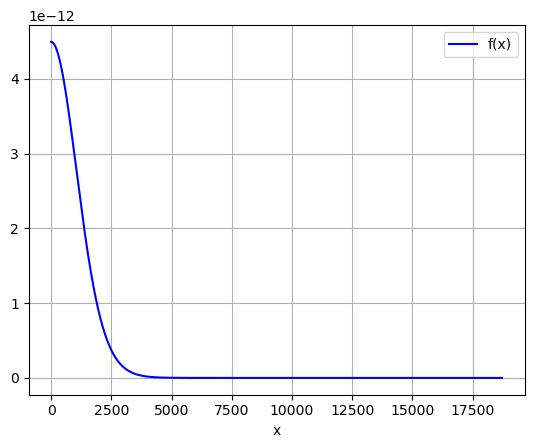

(1000,)


In [2]:
bosonStar = outputProfile(massInCU, aInCU, totalMassInCU)
x = bosonStar["x"]
psi = bosonStar["profile"]

dx = x[1]-x[0]
for i in range(500):
    x = np.append(x, x[-1]+dx)
    psi = np.append(psi, psi[-1])

print(x.shape)

In [3]:
totalMass = massSIToPlanckUnit(massCodeUnitToSI(totalMassInCU))
m = massSIToPlanckUnit(massCodeUnitToSI(massInCU))
a = lengthSIToPlanckUnit(lengthCodeUnitToSI(aInCU))
N = totalMass/m
Ra = np.sqrt(a/m/m/m)
omegaA = m*m/np.abs(a)
epsilon = 1.0/omegaA/m/Ra/Ra
a0 = np.sqrt(1.0/omegaA/m)
delta = 4.0*np.pi*a*N/a0
GM = totalMass/Ra/Ra/Ra/omegaA/omegaA

print("R:", Ra)
print("Omega:" ,omegaA)
print("Epsilon (Should be 1):", epsilon)
print("Delta:", delta)
print("New G:", GM)

R: 3.8684718785837514e+40
Omega: 3.656129092998465e-43
Epsilon (Should be 1): 1.0000000000000002
Delta: 14.839459489461666
New G: 1.180886665279879


In [4]:
x = lengthSIToPlanckUnit(lengthCodeUnitToSI(x))/Ra
psi = np.sqrt(densitySIToPlanckUnit(densityCodeUnitToSI(psi))/totalMass)*np.power(Ra, 3.0/2.0)
normalization = scipy.integrate.simpson(4.0*np.pi*x*x*np.absolute(psi)*np.absolute(psi), x=x)
psi = psi/normalization
psi = psi.astype(complex)

for index, value in enumerate(psi):
    if(value<1e-5):
        psi[index] = 0.0

size = len(psi)
dt = timeSIToPlanckUnit(timeCodeUnitToSI(dtInCU))*omegaA
dx = x[1]-x[0]

print(psi)
print(dt)

[5.83973278e-02+0.j 5.83608193e-02+0.j 5.82878809e-02+0.j
 5.81786701e-02+0.j 5.80334220e-02+0.j 5.78524489e-02+0.j
 5.76361390e-02+0.j 5.73849547e-02+0.j 5.70994308e-02+0.j
 5.67801731e-02+0.j 5.64278553e-02+0.j 5.60432170e-02+0.j
 5.56270607e-02+0.j 5.51802488e-02+0.j 5.47037006e-02+0.j
 5.41983885e-02+0.j 5.36653348e-02+0.j 5.31056077e-02+0.j
 5.25203178e-02+0.j 5.19106136e-02+0.j 5.12776778e-02+0.j
 5.06227230e-02+0.j 4.99469874e-02+0.j 4.92517308e-02+0.j
 4.85382301e-02+0.j 4.78077752e-02+0.j 4.70616646e-02+0.j
 4.63012016e-02+0.j 4.55276897e-02+0.j 4.47424291e-02+0.j
 4.39467125e-02+0.j 4.31418217e-02+0.j 4.23290234e-02+0.j
 4.15095664e-02+0.j 4.06846779e-02+0.j 3.98555608e-02+0.j
 3.90233903e-02+0.j 3.81893119e-02+0.j 3.73544384e-02+0.j
 3.65198479e-02+0.j 3.56865817e-02+0.j 3.48556428e-02+0.j
 3.40279940e-02+0.j 3.32045567e-02+0.j 3.23862100e-02+0.j
 3.15737893e-02+0.j 3.07680864e-02+0.j 2.99698484e-02+0.j
 2.91797778e-02+0.j 2.83985321e-02+0.j 2.76267244e-02+0.j
 2.68649234e-0

In [5]:
T = np.zeros((size,size)).astype(complex)
TSph = np.zeros((size,size)).astype(complex)
Q = np.zeros((size,size)).astype(complex)
V2Grav = np.zeros((size,size)).astype(complex)
I = np.identity(size).astype(complex)
phi = np.zeros((size))

In [6]:
def setupT():
    global T, TSph
    for i in range(size):
        if i==0:
            T[i][i] = -1.0
            T[i][i+1] = 1.0
            b = np.polyfit(x[:3], np.absolute(psi[:3])*np.absolute(psi[:3]), 2)[0]
            TSph[i][i] = 2.0*b*dx
        elif i==size-1:
            T[i][i] = -1.0
            T[i][i-1] = 1.0
            TSph[i][i-1] = -1.0/2.0/x[i]
            TSph[i][i] = 1.0/2.0/x[i]
        else:
            T[i][i] = -2.0
            T[i][i+1] = 1.0
            T[i][i-1] = 1.0
            if i<=2:
                b = np.polyfit(x[:3], np.absolute(psi[:3])*np.absolute(psi[:3]), 2)[0]
                TSph[i][i] = 2.0*b*dx
            else:
                TSph[i][i+1] = 1.0/2.0/x[i]
                TSph[i][i-1] = -1.0/2.0/x[i]

    T = -1.0/2.0/dx/dx*T
    TSph = -1.0/dx*TSph

def setupQ():
    global Q
    for i in range(size):
        Q[i][i] = delta*np.absolute(psi[i])*np.absolute(psi[i])

def setupV2Grav():
    global V2Grav, phi, psi

    rho = np.absolute(psi)*np.absolute(psi)
    rho_c = (c_double * size)(*rho)
    phi_c = (c_double * size)(*np.absolute(phi))
    my_func.findGravRho(rho_c, phi_c, c_int(size), c_double(dx))
    for i in range(size):
        phi[i] = phi_c[i] * GM

    for i in range(size):
        V2Grav[i][i] = phi[i]

def setupU1U2():
    global U1, U2
    U1 = I + 1.0j*dt/2.0*(T+TSph+Q+V2Grav)
    U2 = I - 1.0j*dt/2.0*(T+TSph+Q+V2Grav)

0 0.0 0.059629186773778285 1.0001071004936417
1 0.6680821710326822 0.05961919572237541 1.0001065640510534
2 1.3361643420653644 0.05970828166136529 1.0001049363964074
3 2.0042465130980465 0.060454122343462834 1.0000917045454951
4 2.6723286841307288 0.060690786297855424 1.0000868868459902
5 3.340410855163411 0.06135336726839117 1.000074994600546
6 4.008493026196093 0.06188126371677057 1.0000648110939503
7 4.676575197228775 0.06248393629871118 1.0000536331510625
8 5.3446573682614575 0.06310874000138722 1.000041534368065
9 6.01273953929414 0.06374456351054605 1.0000294115806618
10 6.680821710326822 0.06431425864535249 1.000018193663693
11 7.3489038813595045 0.06474040628790521 1.000009946880172
12 8.016986052392186 0.06499744037088201 1.000004719561795
13 8.685068223424869 0.06518525079485427 1.000001103442025
14 9.35315039445755 0.06527470290647969 0.9999991995069383
15 10.021232565490234 0.06533417450297886 0.9999980938517644
16 10.689314736522915 0.0653409937244791 0.9999978700579062
17

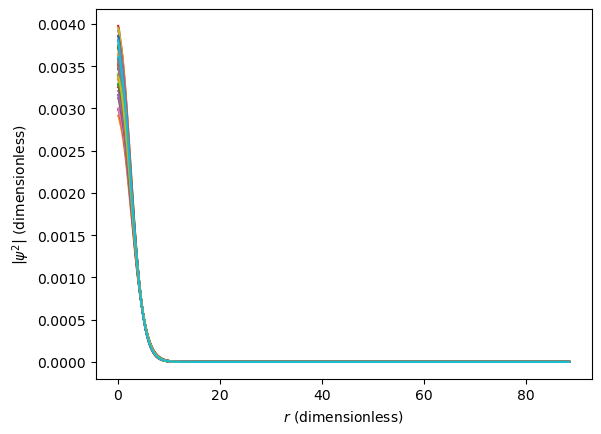

In [7]:
setupT()
setupQ()
setupV2Grav()
setupU1U2()

hello = []
hello2 = []
ts = []
oldGM = GM
newGM = GM*1.2
for t in range(bigT):
    #Pertubation
    if(t==0):
        GM = newGM
    if(t==10):
        GM = oldGM

    setupQ()
    setupV2Grav()
    setupU1U2()
    psi = np.linalg.solve(U2, np.dot(U1,psi))

    normalization = scipy.integrate.simpson(4.0*np.pi*x*x*np.absolute(psi)*np.absolute(psi), x=x)
    #if(normalization >= 1.01):
    #    break
    print(t, t*dt, np.absolute(psi[0]), normalization)
    if(GM == oldGM):

        def findMass():
            for i in range(size):
                if(i != 0):
                    temp = scipy.integrate.simpson(4.0*np.pi*x[:i]*x[:i]*np.absolute(psi[:i])*np.absolute(psi[:i]), x=x[:i])
                    if(temp > 0.99):
                        return i
            return size-1
            
        hello2.append(findMass())

        hello.append(np.absolute(psi[0])*np.absolute(psi[0]))
        ts.append(t*dt)

    if t%100 == 0:
        plt.plot(x, np.absolute(psi)*np.absolute(psi))

plt.xlabel(r"$r$ (dimensionless)")
plt.ylabel(r"$\left | \psi^2 \right |$ (dimensionless)")
plt.show()

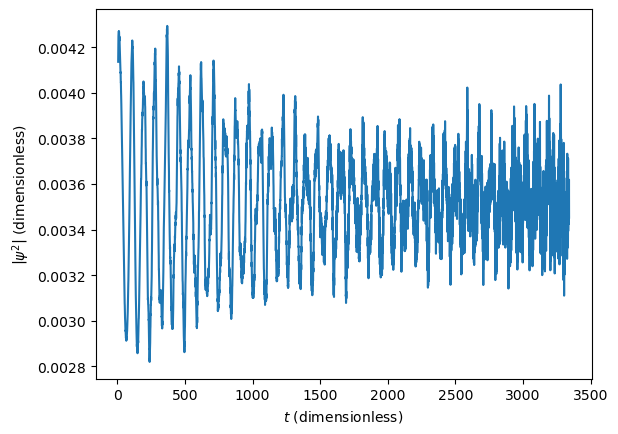

In [8]:
plt.plot(ts, hello)
plt.xlabel(r"$t$ (dimensionless)")
plt.ylabel(r"$\left | \psi^2 \right |$ (dimensionless)")
plt.show()

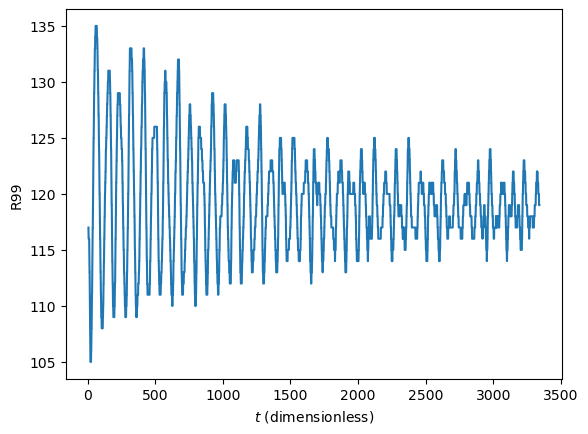

In [9]:
plt.plot(ts, hello2)
plt.xlabel(r"$t$ (dimensionless)")
plt.ylabel(r"R99")
plt.show()

Text(0.5, 0, 'f (1/s)')

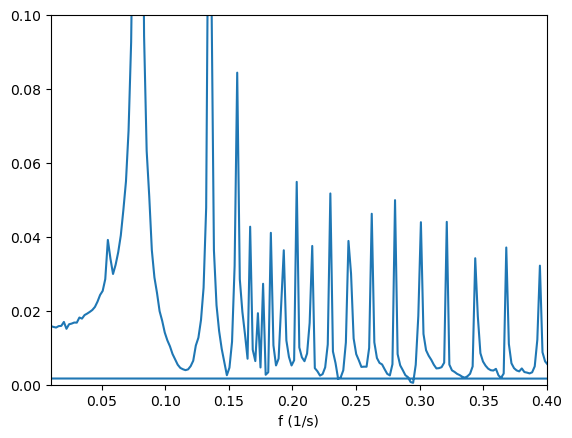

In [10]:
sp = np.fft.fft(hello)
freq = np.fft.fftfreq(len(hello), d=dt)*omegaA/5.391247e-44

plt.plot(freq, np.absolute(sp))
plt.xlim(0.01,0.4)
plt.ylim(0.0,0.1)
plt.xlabel("f (1/s)")

In [11]:
print(freq[1]-freq[0])
for i in range(len(freq)-1):
    if(freq[i] > 0.0 and np.absolute(sp[i]) > 0.04 and np.absolute(sp[i])>np.absolute(sp[i+1]) and np.absolute(sp[i])>np.absolute(sp[i-1])):
        print(freq[i], np.absolute(sp[i]))

0.0020342384769539076
0.0793353006012024 0.7036957249001754
0.13425973947895792 0.150493221937805
0.15663636272545087 0.08443274268140957
0.16680755511022044 0.042755496600906585
0.1830814629258517 0.04109872284387255
0.2034238476953908 0.05488503350864924
0.2298689478957916 0.05174920128467085
0.2624167635270541 0.04625946023366054
0.28072490981963927 0.04994088673127437
0.30106729458917836 0.04397202146416002
0.32140967935871745 0.044068162754840344
3.360561963927856 0.04005523838342495


Text(0.5, 0, 'f (1/s)')

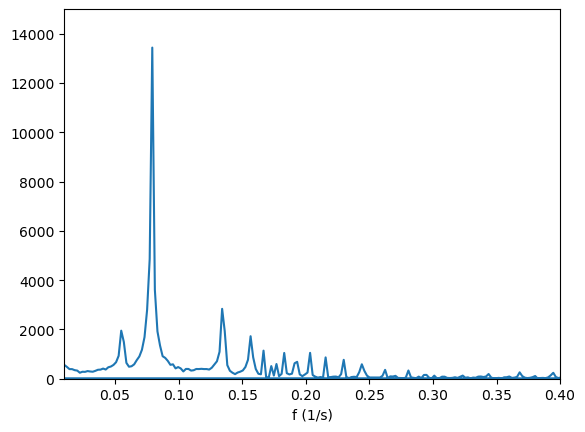

In [12]:
sp = np.fft.fft(hello2)
freq = np.fft.fftfreq(len(hello2), d=dt)*omegaA/5.391247e-44

plt.plot(freq, np.absolute(sp))
plt.xlim(0.01,0.4)
plt.ylim(0.0,15000)
plt.xlabel("f (1/s)")

In [13]:
print(freq[1]-freq[0])
for i in range(len(freq)-1):
    if(freq[i] > 0.0 and np.absolute(sp[i]) > 1000 and np.absolute(sp[i])>np.absolute(sp[i+1]) and np.absolute(sp[i])>np.absolute(sp[i-1])):
        print(freq[i], np.absolute(sp[i]))

0.0020342384769539076
0.054924438877755506 1949.727795640179
0.0793353006012024 13438.651505922253
0.13425973947895792 2836.6965900162018
0.15663636272545087 1724.9784697126195
0.16680755511022044 1139.8384187191273
0.1830814629258517 1045.3723248654198
0.2034238476953908 1049.8090266424347


[5.87606146e-02 5.87005415e-02 5.85672097e-02 5.83504828e-02
 5.81613930e-02 5.79546228e-02 5.77153197e-02 5.74424304e-02
 5.71423878e-02 5.68057403e-02 5.64313266e-02 5.60221591e-02
 5.55870662e-02 5.51186404e-02 5.46163829e-02 5.40866474e-02
 5.35392920e-02 5.29707208e-02 5.23769535e-02 5.17661944e-02
 5.11430604e-02 5.05041497e-02 4.98392000e-02 4.91570633e-02
 4.84618464e-02 4.77506115e-02 4.70154421e-02 4.62632914e-02
 4.55038837e-02 4.47301309e-02 4.39383256e-02 4.31322463e-02
 4.23235559e-02 4.15069246e-02 4.06757026e-02 3.98383830e-02
 3.90015003e-02 3.81646394e-02 3.73203135e-02 3.64757596e-02
 3.56409645e-02 3.48114423e-02 3.39843466e-02 3.31618457e-02
 3.23501304e-02 3.15472557e-02 3.07465340e-02 2.99523980e-02
 2.91687756e-02 2.83955570e-02 2.76320223e-02 2.68773769e-02
 2.61346940e-02 2.54040911e-02 2.46830349e-02 2.39705186e-02
 2.32656009e-02 2.25713255e-02 2.18896408e-02 2.12169690e-02
 2.05533679e-02 1.99035007e-02 1.92691667e-02 1.86472660e-02
 1.80361820e-02 1.744109

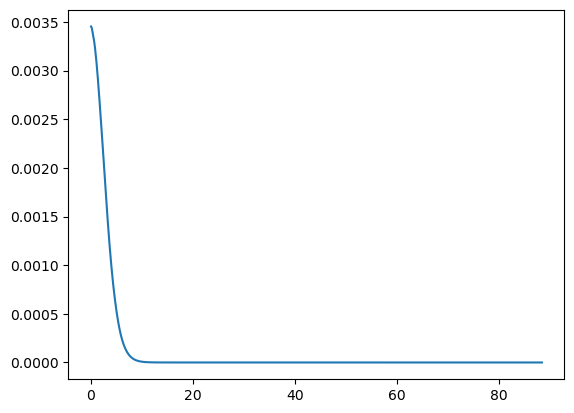

In [14]:
plt.plot(x, np.absolute(psi)*np.absolute(psi))
print(np.absolute(psi))

Middle
0.071-0.081			M1 (M2: 0.142-0.162, M3: 0.213-0.243, M4: 0.284-0.324, M5: 0.355-0.405)
0.132-0.137			M1?
0.158-0.163			M2
0.193-0.204			M1?
0.239-0.249			M3
0.295-0.305			M4
0.361-0.371			M5

0.076-0.086			M1
0.132-0.142			M1?
0.158-0.168			M2

Small
0.097-0.107		M1
0.163-0.173		M1?
0.214-0.224		M2
0.270-0.280		M1?
0.341-0.351		M3
0.432-0.443		M4
0.534-0.544		M5
0.651-0.661		M6

Heavy
0.031-0.037		M1
0.058-0.065		M2
0.072-0.078		M?
0.082-0.089		M?
0.099-0.167 	M3
0.116-0.123		M4
0.140-0.147		M5
0.167-0.173		M6?
0.194-0.201 	M7?